**OBSERVATIONS ON DATA :**


1.   The dataset is quite big with over 21000 chess positions
2.   the dataset is fairly balanced with each class having at least 7000 game positions so no need to balance it as seen below



In [ ]:
import pandas as pd

data = pd.read_csv('/content/train (3).csv')
data['evaluation'].value_counts()

,count
evaluation,
white,7300
black,7160
equal,7000




---



one peculiar thing that i noticed about the images was that all the images had the same piece theme which means that shape of pieces and the color orientation of the board is the same in all images which proved to be a great help for my CNN which i will be using further


---

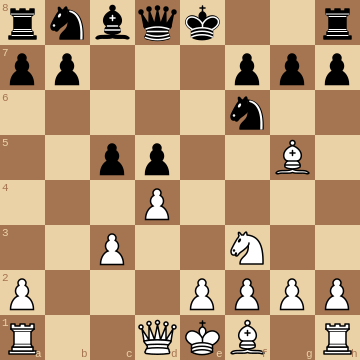



---



**MY APPROACH OVERVIEW**


*   At the first glance i thought of using CNN directly onto the chess images but i ruled out that approach due to the fact that I look at CNN as a feature extracter and not for recognizing patterns in a complex chess position
*   So i thought of converting the image into **FEN** notations first then it would be easier for the models to understand the patterns in a smaller 8X8 grid rather than a huge 360X360 grid (it didnt turn out to be easy though hehe)

**THE IDEA (JUGAD)**


*   the dataset along with the resources were limited and didnt allow me to directly convert the chess board image to FEN
*   I decided to crop the image of each piece(black and white seperately) from the board images and then label them myself so i got total 26 images labelled around 13 classes(12 pieces and also a blank square)

*   Then i went on to train a CNN on my labelled set of pieces so that later on I would run that model on each of the 64 squares for each image and predict the piece.
*   At this point the peculiar point i mentioned above comes into picture


*   Since all the pieces looked same in all the chess boards i just had to duplicate the images that i labelled so i made around 98 duplictes and now i had 100 images of each piece which i could easily use to train my CNN


---


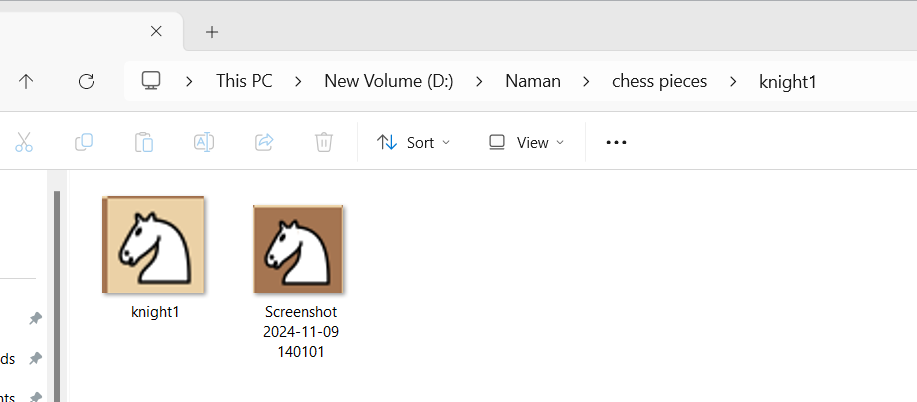












 above are the example images of white knight which are in a folder called knight1 where knight represents the piece while 1 represents white



Below is the code for CNN training

In [ ]:
import os
import shutil
from PIL import Image

def duplicate_images(src_dir, dest_dir, num_duplicates):
    """
    Duplicates the images in a directory to a specified number of times.
    """
    # Check if destination directory exists, if not create it
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    # Iterate over each folder (representing each piece)
    for folder in os.listdir(src_dir):
        folder_path = os.path.join(src_dir, folder)

        if os.path.isdir(folder_path):
            # Create the destination folder for the current piece type (e.g., knight1)
            class_dest_dir = os.path.join(dest_dir, folder)
            if not os.path.exists(class_dest_dir):
                os.makedirs(class_dest_dir)

            # Get the list of images in the folder
            images = os.listdir(folder_path)
            num_images = len(images)

            # If the number of images is less than the desired duplicates, duplicate them
            while num_images < num_duplicates:
                for image in images:
                    image_path = os.path.join(folder_path, image)
                    img = Image.open(image_path)

                    # Copy and save the image until the desired number is reached
                    new_image_name = f"{num_images}_{image}"
                    new_image_path = os.path.join(class_dest_dir, new_image_name)
                    img.save(new_image_path)
                    num_images += 1

                if num_images >= num_duplicates:
                    break


src_dir = '/content/extracted_pieces/chess pieces'
dest_dir = '/content/duplicated_pieces'
num_duplicates = 100

duplicate_images(src_dir, dest_dir, num_duplicates)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
import zipfile
import os

zip_file = '/content/chess pieces.zip'
extract_dir = '/content/extracted_pieces/'

# Unziping the file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


In [ ]:
# Setting image size to 45x45 pixels
img_size = (45, 45)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1.0/255.0)
train_generator = train_datagen.flow_from_directory(
    '/content/duplicated_pieces',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 1274 images belonging to 13 classes.


In [ ]:
# model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Note you are only seeing the last 10 epochs i have trained on almost a 100 epochs and to be honest because the classification here was prety simple even 30-40 epochs would have been enough**

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 10
history = model.fit(train_generator, epochs=epochs)


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.9997 - loss: 8.6348e-04
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9981 - loss: 0.0034
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.6206e-06
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 1.0000 - loss: 4.9197e-05
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 1.0000 - loss: 2.7748e-04
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.9999 - loss: 4.7910e-04
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9989 - loss: 0.0031
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 1.0520e-06
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 1.0000 - loss: 1.5865e-05
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 1.0000 - loss: 5.3784e-06


**Additional info hehe (may skip if in a hurry)**


*   so initally i tried using computer vision(opencv) for the task of comparing each piece image with the board square but the problem was its accuracy
*   look the way opencv works is on a pixel level it literally slides the object to be found over the entire image to serch for it and gives a matching score for each square

*   0 score indicates a perfect match and i had to decide the margin so the problem was that for a higher margin say 0.15 it couldnt distinguish between pawns and bishops (since bishops are just pawns with pointed hats hehe :) nevermind  ) whereas on decreasing the margin it just treated all the sqaures as blank
*   So i though for a while and decided to switch to the CNN approach







---



**MOVING ON TO THE RESULT OF MY CNN MODEL**

In [ ]:
# trying the model on a random chess image
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the chessboard PNG image
chessboard_image_path = '/content/10006078.png'
chessboard_image = cv2.imread(chessboard_image_path)

chessboard_resized = cv2.resize(chessboard_image, (360, 360))

In [ ]:
# Dimensions of each square on the chessboard
square_size = 45
num_rows, num_cols = 8, 8

# List to store the 64 squares
squares = []

# Extract squares
for i in range(num_rows):
    for j in range(num_cols):
        x_start = j * square_size
        y_start = i * square_size
        x_end = (j + 1) * square_size
        y_end = (i + 1) * square_size

        square = chessboard_resized[y_start:y_end, x_start:x_end]
        squares.append(square)


In [ ]:
def preprocess_square(square):
    # Convert the image to RGB
    square_rgb = cv2.cvtColor(square, cv2.COLOR_BGR2RGB)
    square_resized = cv2.resize(square_rgb, (45, 45))
    square_normalized = square_resized / 255.0
    square_batch = np.expand_dims(square_normalized, axis=0)

    return square_batch

# the 2D matrix of the chessboard
chessboard_matrix = []

# Classify each square using the model
for square in squares:
    square_batch = preprocess_square(square)
    prediction = model.predict(square_batch)

    # Get the class index with the highest probability
    predicted_class = np.argmax(prediction)
    chessboard_matrix.append(predicted_class)

chessboard_matrix = np.array(chessboard_matrix).reshape((8, 8))

print(chessboard_matrix)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

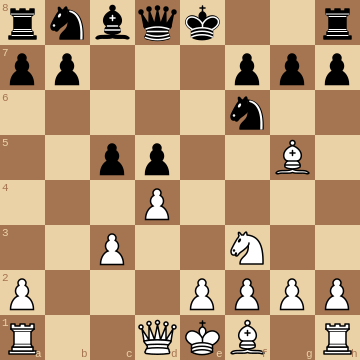

**Above is the test image along with its coressponding 2D matrix**


---



I thought the numbers were not making much sense so i just mapped the numbers to their corresponding pieces to get a more structured 2D matrix

In [ ]:
class_mapping = {
    2: 'empty',
    7: 'pawn1',
    8: 'pawn2',
    5: 'knight1',
    6: 'knight2',
    0: 'bishop1',
    1: 'bishop2',
    11: 'rook1',
    12: 'rook2',
    9: 'queen1',
    10: 'queen2',
    3: 'king1',
    4: 'king2',

}

board_with_pieces = np.vectorize(lambda x: class_mapping.get(x, 'empty'))(chessboard_matrix)

print(board_with_pieces)


[['rook2' 'knight2' 'bishop2' 'queen2' 'king2' 'empty' 'empty' 'rook2']
 ['pawn2' 'pawn2' 'empty' 'empty' 'empty' 'pawn2' 'pawn2' 'pawn2']
 ['empty' 'empty' 'empty' 'empty' 'empty' 'knight2' 'empty' 'empty']
 ['empty' 'empty' 'pawn2' 'pawn2' 'empty' 'empty' 'bishop1' 'empty']
 ['empty' 'empty' 'empty' 'pawn1' 'empty' 'empty' 'empty' 'empty']
 ['empty' 'empty' 'pawn1' 'empty' 'empty' 'knight1' 'empty' 'empty']
 ['pawn1' 'empty' 'empty' 'empty' 'pawn1' 'pawn1' 'pawn1' 'pawn1']
 ['rook1' 'empty' 'empty' 'queen1' 'king1' 'bishop1' 'empty' 'rook1']]




---



**FINAL MODEL TRAINING FOR PREDICTION**


*   the difficult part is over and now i was just debating on whether to use an ANN or a CNN again
*   I decided to go ahead with CNN due to the fact that i found it more intutive to keep the grid in its original 8X8 format which is alright for CNN but for ANN i had to flaten it first into a 1D matrix which i did'nt like to be honest



# **BUT BUT BUT THE STRUGGLE WAS'NT OVER**

So before going toward training I had to convert the entire train and test image dataset into the 2D matrix form which comes out to be around 30000 iamges (22000 train and 8000 test)
but the problem was even with GPU the time taken to convert 100 images was around 10-15 mins which comes out to be more that 3000 minutes for both dataset (crying emojis) and since i was taking part as a solo warrior obviously i couldnt convert all the train images

**SOLUTION (OR AT LEAST A TRY)**


*   since the conversion of train datset was a compultion if i had to submit their prediction i had to convert them first which consumed a lot of time
*   In the remaining time i tried to convert the train dataset as well but i couldnt with my free colab version and limited gpu access i could convert only 5000 train images and got a validation score of about 60% which is quite bad according to me huhh!!

*   so on this scale according to my expectations i would have at least reached a score of 80% if had the time and resources to convert all the train images which sadly I did'nt
*   so below is the code if anyone in the future has got that much time can check for all the datset :)





In [ ]:
import json
import pandas as pd

# Load the CSV file into a dictionary with ID as key and evaluation as value
labels_df = pd.read_csv("/content/train (3).csv")
id_to_evaluation = dict(zip(labels_df["id"].astype(str), labels_df["evaluation"]))  # Convert IDs to strings

filtered_data = []

# Load JSON data and filter for IDs present in CSV
with open("/content/output (7).json", "r") as f:
    for line in f:
        batch = json.loads(line)

        for entry in batch:
            # Normalize the structure: convert list format to dictionary format if necessary
            if isinstance(entry, list) and len(entry) == 2:
                image_id, matrix = entry
                entry = {"ID": str(image_id), "Matrix": matrix}  # Convert ID to string
            elif isinstance(entry, dict):
                image_id = str(entry["ID"])  # Convert ID to string

            # Check if the ID exists in the CSV file
            if image_id in id_to_evaluation:
                entry["Evaluation"] = id_to_evaluation[image_id]  # Add evaluation to entry
                filtered_data.append(entry)  # Add entry to filtered data
            else:
                # Print IDs that are not found in the CSV dictionary
                print(f"ID {image_id} not found in CSV data")

# If filtered_data is still empty, this means there were no matching IDs
if not filtered_data:
    print("No matching IDs found between JSON and CSV data.")
else:
    # Save the filtered data with evaluations to a new JSON file
    with open("filtered_chess_data.json", "w") as f:
        json.dump(filtered_data, f)

print(f"Number of matching entries: {len(filtered_data)}")


Number of matching entries: 3800


**Just to show you below is a part of the json file i generated after converting those images to matrices**

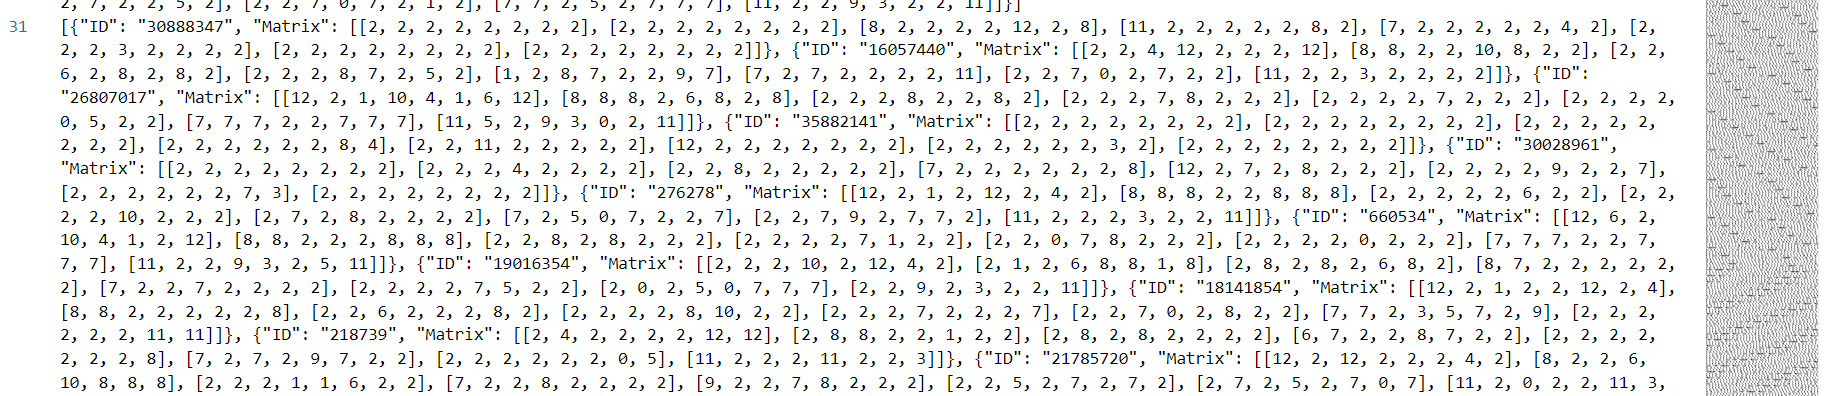

AS you can see we have the ID of the image and its corresponding matrix alongside

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

with open("filtered_chess_data.json", "r") as f:
    data = json.load(f)

X = []
y = []

label_mapping = {"white": 0, "black": 1, "equal": 2}

for entry in data:
    matrix = np.array(entry["Matrix"])
    label = label_mapping[entry["Evaluation"]]
    X.append(matrix)
    y.append(label)

X = np.array(X).reshape(-1, 8, 8, 1)
y = to_categorical(y, num_classes=3)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(8, 8, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # Three output classes: white, black, equal
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Training the model
history = model.fit(X_train, y_train, epochs=1000, batch_size=100, validation_data=(X_val, y_val))


Epoch 1/1000
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9682 - loss: 0.0774 - val_accuracy: 0.6171 - val_loss: 3.8004
Epoch 2/1000
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9734 - loss: 0.0688 - val_accuracy: 0.6158 - val_loss: 3.8129
Epoch 3/1000
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9718 - loss: 0.0698 - val_accuracy: 0.6092 - val_loss: 3.7808
Epoch 4/1000
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9775 - loss: 0.0637 - val_accuracy: 0.6132 - val_loss: 3.7974
Epoch 5/1000
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9670 - loss: 0.0697 - val_accuracy: 0.6197 - val_loss: 3.8427
Epoch 6/1000
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9819 - loss: 0.0550 - val_accuracy: 0.6184 - val_loss: 3.9038
Epoch 7/1000
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9804 - loss: 0.0555 - val_accuracy: 0.6184 - val_loss: 3.8664
Epoch 8/1000
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9793 - loss: 0.0511 - val_accuracy: 0.

KeyboardInterrupt: 

**TESTING**

In [ ]:
import json
import numpy as np
import pandas as pd

with open("test.json", "r") as f:
    test_data = json.load(f)

test_ids = []
test_matrices = []

for entry in test_data:
    # Ensure the entry is in the expected dictionary format
    if isinstance(entry, list) and len(entry) == 2:
        test_id, matrix = entry
    elif isinstance(entry, dict):
        test_id = entry["ID"]
        matrix = entry["Matrix"]

    test_ids.append(test_id)
    test_matrices.append(matrix)

X_test = np.array(test_matrices).reshape(-1, 8, 8, 1)

predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

label_mapping = {0: "white", 1: "black", 2: "equal"}
predicted_labels = [label_mapping[pred] for pred in predicted_classes]

output_df = pd.DataFrame({"ID": test_ids, "Prediction": predicted_labels})
output_df.to_csv("test_predictions.csv", index=False)

print("Predictions saved to test_predictions.csv")


**This way we got our required CSV file**

## **FINAL CONCLUSION AND THE IMPROVEMENTS I COULD HAVE MADE WITH MORE TIME**


*   the current accuracy is low but could be improved upto 80-85% if trained on entire dataset
*   CNN alone can understand the patterns in a chess position by feature extraction but fails when the position becomes more tactical

*   the best way to evaluate a chess position is just by pure calculation wherin we make a tree of a pre defined depth that is till where we have to calculate and then use the minimax algorithm along with alpha beta prunning i was planning to do that but again that would bascially mean that i would be creating a chess engine from scratch which would take a lot of time
*   All in all i agree i made amistake by starting late but the ideas i came up with along with the new things i learnt while creating this notebook are more important than tne price



